In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from pyorg.core.geometry import get_cells_area

import pycompo.filter as pcfilter
import pycompo.wind as pcwind
import pycompo.sst_features as pcsst
import pycompo.coord as pccoord
import pycompo.plot as pcplot
import pycompo.feature_cutout as pcfeatcut
import pycompo.ellipse as pcellipse
from pycompo.composite import interpolate2compo_coords

### User settings

In [3]:
# basic data settings
exp = "ngc5004"
analysis_var = "ts"
wind_vars = ("uas", "vas")
study_vars = ["pr", "prw", "hfls", "hfss"]
spd = 8
analysis_year = 2020
inpaths = {
    analysis_var: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{analysis_var}_latlon/'
    ),
    wind_vars[0]: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{wind_vars[0]}_latlon/'
    ),
    wind_vars[1]: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{wind_vars[1]}_latlon/'
    ),
    study_vars[0]: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{study_vars[0]}_latlon/'
    ),
    study_vars[1]: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{study_vars[1]}_latlon/'
    ),
    study_vars[2]: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{study_vars[2]}_latlon/'
    ),
    study_vars[3]: Path(
        f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/' +
        f'{study_vars[3]}_latlon/'
    ),
}

# basic analysis settings
lat_range = (-15., 15.)

# filtering settings
clim_avg_days = 30
lat_mid = 0  # degrees — adjust this based on your domain center
cutoff_scale_km = 300.
filter_truncation = 1  # filter_trunction=1 works well, otherwise to much data discarded due to islands

# sst-feature detection settings
dT_thresh = 0.2     # |SSTA| above this threshold will be detected
feature_connectivity = 8
feature_norm_type = "ellipse"
feature_min_area = 2500 # km^2
feature_props_list = [
    'centroid', 'area', 'axis_major_length', 'axis_minor_length', 'orientation',
    #'intensity_mean',
    ]

# data_cutout_sample seettings
search_RadRatio = 3. #Data within a box with an edge length of L_maj times this factor will be extracted

# composite settings
anomaly_modes = ['warm']
compo_x = np.arange(-2.5, 2.6, 0.1)
compo_y = np.arange(-2.5, 2.6, 0.1)

### Read in data

In [7]:
varlst = [
    analysis_var, wind_vars[0], wind_vars[1], study_vars[0], study_vars[1],
    study_vars[2], study_vars[3],
    ]

# Read in data for analysis
infiles = []
for var in varlst:
    in_pattern = f'{exp}_tropical_{var}_20200801T000000Z-20200901T000000Z.nc'
    infiles.extend(sorted([str(f) for f in inpaths[var].rglob(in_pattern)]))
dset = xr.open_mfdataset(infiles, parallel=True).squeeze()
dset = dset.isel(time=slice(0, 2))
for var in (list(wind_vars) + study_vars): dset[var] = dset[var].compute()

dset['sfcwind'] = pcwind._calc_sfcwind_speed(dset['uas'], dset['vas'])
dset['cell_area'] = get_cells_area(dset)

### Building SST anomalies
##### Infos on the filtering in degree space
Here we use a characteristic wavelength in degree since this has three advantages:
1) We remove the necessity to transform to km and can easily use a Gaussian filter
2) Ocean eddies - and thus temperature anomalies - tend to become smaller towards higher latitudes due to the Coriolis effect. Thus, cutting at a certain wavenumber instead of a certain wavelength is also physically reasonable.
3) We are in the deep tropics where the difference between longitudes and distances is small anyways.

Nevertheless, the charcateristic wavenumber has to be submitted as a characteristic wavelength at the equator -- it will be transformed internally.

In [8]:
# Gaussian filter to extract anomalies
dset = xr.merge([
    dset,
    pcfilter.get_gaussian_filter_bg_ano(
        dset.drop(['cell_area', 'uas', 'vas', 'height_2']),
        lat_mid=lat_mid, Lc_km=cutoff_scale_km, truncate=filter_truncation,
        )
    ])
dset = dset.sel(lat=slice(lat_range[0], lat_range[1]), drop=True)
orig_coords = pccoord.get_coords_orig(dset)

### Detection of SST clusters and cutout of corresponding data

In [10]:
dset['sst_feature'], feature_props = pcsst.extract_sst_features(
    dset['ts_ano'], threshold=dT_thresh, connectivity=feature_connectivity, 
    property_list=feature_props_list, feature_min_area=feature_min_area
    )
dset, feature_props, feature_data = pcfeatcut.get_featcen_data_cutouts(
    dset, feature_props, search_RadRatio,
    )

feature_ellipse = pcellipse.get_ellipse_params(feature_props, orig_coords)

feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_data, wind_vars,
    )
feature_data = pccoord.add_featcen_coords(
    orig_coords, feature_data, feature_props, feature_ellipse,
    )

### Visualization of the SST clusters

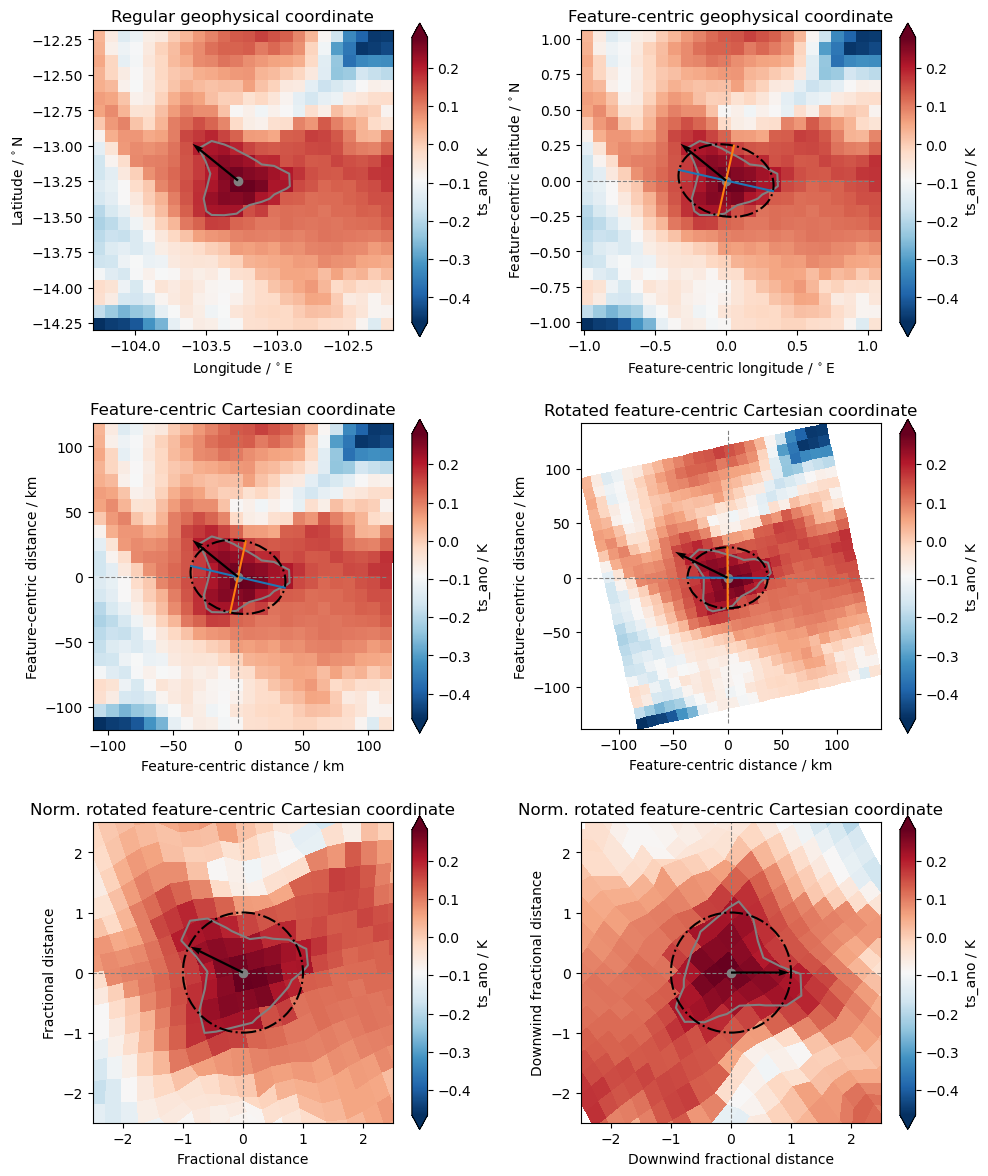

In [28]:
import importlib as implib
implib.reload(pcplot)

feature_id = 1
data = feature_data[feature_id]
props = feature_props.isel(feature=feature_id)
wind = feature_props[['bg_uas', 'bg_vas']]
pcplot.plot_coord_trafo(
    feature_data, feature_ellipse, wind, feature_id, f'{analysis_var}_ano',
    dT_thresh,
    )

### Create composite

In [ ]:
compo_varlst = [
    f'{analysis_var}_ano', 'pr_ano', 'prw_ano', 'hfls_ano', 'hfss_ano',
    'sfcwind_ano',
    ]
feature_compo_data = {
    var: interpolate2compo_coords(feature_data, (compo_x, compo_y), var)
    for var in compo_varlst
    }
feature_compo_data = xr.merge([feature_compo_data[var] for var in compo_varlst])

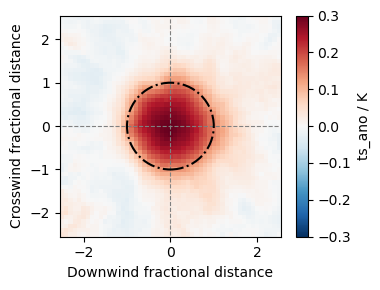

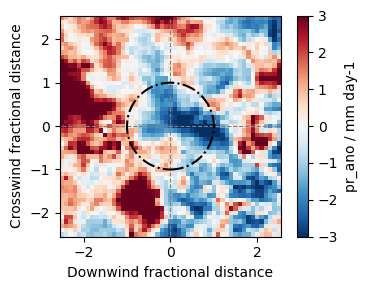

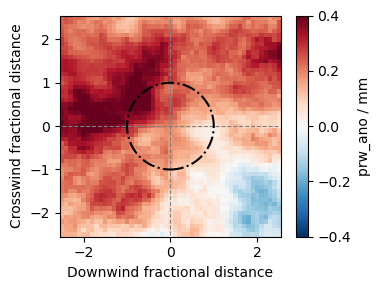

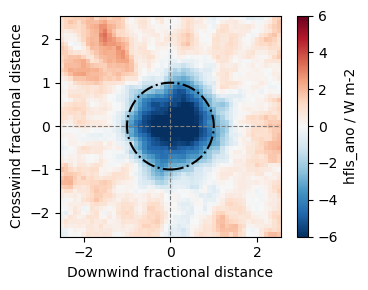

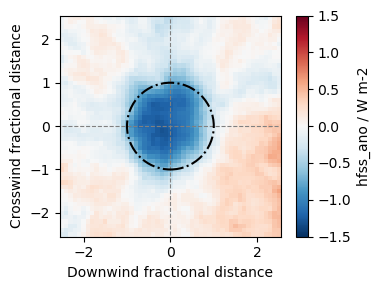

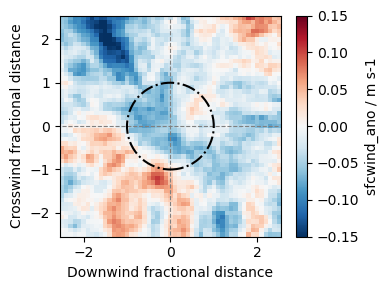

In [32]:
import importlib as implib
implib.reload(pcplot)

for var in compo_varlst:
    pcplot.plot_composite(feature_compo_data[var])